In [31]:
from ctapipe.image.extractor import integration_correction, extract_around_peak
from sstcam_simulation import Camera, EventAcquisition
from sstcam_simulation.event import Photoelectrons
from sstcam_simulation.camera.noise import PerfectElectronics
from glob import glob
from os.path import join
import re
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

In [32]:
directory = "/Users/Jason/Software/sstcam-labbook/d200626_undershoot/cameras"
h5_paths = glob(join(directory, "*.h5"))

In [134]:
pe = Photoelectrons(time=np.array([30]), charge=np.array([1]), pixel=np.array([0]))

In [135]:
df = []

pattern = r".*\/undershoot_(.+)_(.+)_lab.h5"
for h5_path in tqdm(h5_paths):
    camera_path = h5_path.replace("_lab.h5", ".pkl")
    regexr = re.search(pattern, h5_path)
    sigma0 = float(regexr.group(1))
    sigma1 = float(regexr.group(2))

    camera = Camera.load(camera_path)
    #camera = Camera()
    camera.mapping.reinitialise(1)
    super(type(camera), camera).__setattr__('readout_noise', PerfectElectronics())
    acquisition = EventAcquisition(camera=camera)
    readout = acquisition.get_continuous_readout(pe)
    waveform = acquisition.get_sampled_waveform(readout)
    
    charge, _ = extract_around_peak(
        waveform, 30, 8, 3, 1
    )
    
    correction = integration_correction(
        camera.reference_pulse.pulse[None, :],
        camera.continuous_readout_sample_width,
        camera.waveform_sample_width,
        8, 3
    )
    
    df.append(dict(
        sigma0=sigma0,
        sigma1=sigma1,
        charge=charge[0],
        correction=correction[0],
        result=(charge * correction)[0],
    ))
    
df = pd.DataFrame(df)

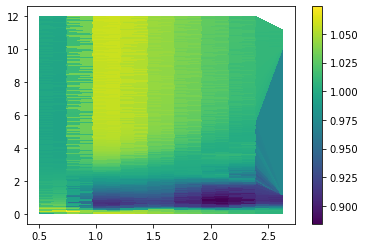

In [136]:
plt.tripcolor(df['sigma0'], df['sigma1'], df['result'])
plt.colorbar()

In [120]:
np.unique(df['sigma1'])

array([ 0.  ,  0.12,  0.24,  0.36,  0.48,  0.61,  0.73,  0.85,  0.97,
        1.09,  1.21,  1.33,  1.45,  1.58,  1.7 ,  1.82,  1.94,  2.06,
        2.18,  2.3 ,  2.42,  2.55,  2.67,  2.79,  2.91,  3.03,  3.15,
        3.27,  3.39,  3.52,  3.64,  3.76,  3.88,  4.  ,  4.12,  4.24,
        4.36,  4.48,  4.61,  4.73,  4.85,  4.97,  5.09,  5.21,  5.33,
        5.45,  5.58,  5.7 ,  5.82,  5.94,  6.06,  6.18,  6.3 ,  6.42,
        6.55,  6.67,  6.79,  6.91,  7.03,  7.15,  7.27,  7.39,  7.52,
        7.64,  7.76,  7.88,  8.  ,  8.12,  8.24,  8.36,  8.48,  8.61,
        8.73,  8.85,  8.97,  9.09,  9.21,  9.33,  9.45,  9.58,  9.7 ,
        9.82,  9.94, 10.06, 10.18, 10.3 , 10.42, 10.55, 10.67, 10.79,
       10.91, 11.03, 11.15, 11.27, 11.39, 11.52, 11.64, 11.76, 11.88,
       12.  ])

In [133]:
camera_path = join(directory, "undershoot_0.50_0.48.pkl")
camera = Camera.load(camera_path)

camera.mapping.reinitialise(1)
super(type(camera), camera).__setattr__('readout_noise', PerfectElectronics())
acquisition = EventAcquisition(camera=camera)
readout = acquisition.get_continuous_readout(pe)
waveform = acquisition.get_sampled_waveform(readout)

shift = 3
width = 8

pulse_max_sample = camera.reference_pulse.pulse.size * camera.continuous_readout_sample_width
pulse_shape_x = np.arange(0, pulse_max_sample, camera.continuous_readout_sample_width)
sampled_edges = np.arange(0, pulse_max_sample, camera.waveform_sample_width)

sampled_pulse, _ = np.histogram(
    pulse_shape_x, sampled_edges, weights=camera.reference_pulse.pulse, density=True
)
#sampled_pulse = camera.reference_pulse.pulse.reshape((128, 5)).sum(1)
#sampled_pulse /= sampled_pulse.sum()
n_samples = sampled_pulse.size
start = sampled_pulse.argmax() - shift
start = start if start >= 0 else 0
end = start + width
end = end if end < n_samples else n_samples

integration = np.sum(sampled_pulse[start:end]) * camera.waveform_sample_width

charge, _ = extract_around_peak(
    waveform, 30, width, shift, 1
)

correction = integration_correction(
    camera.reference_pulse.pulse[None, :],
    camera.continuous_readout_sample_width,
    camera.waveform_sample_width,
    width, shift
)

print(charge * correction)
print(integration, charge, correction)

1.0000000000000002
[1.08464787]
1.5886009597228932 [1.7230726] [0.6294847]


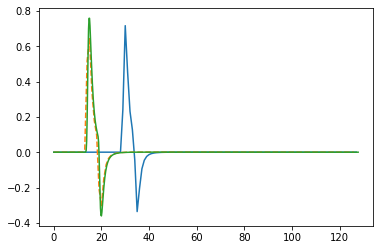

In [128]:
plt.plot(waveform[0])
plt.plot(sampled_pulse, '--')
plt.plot(camera.reference_pulse.time, camera.reference_pulse.pulse)
#plt.axvline(30)

In [95]:
np.sum(sampled_pulse) * camera.waveform_sample_width

0.9999999999999999

In [96]:
np.sum(waveform[0]) * camera.waveform_sample_width

0.9943497240842896

In [85]:
print(np.sum(waveform[0, 30-3:30-3+8]))
print(np.sum(waveform[0, waveform.argmax()-3:waveform.argmax()-3+8]))

1.4267862883296676
1.4267862883296676


In [86]:
waveform.argmax()

30

In [88]:
waveform.size

128